In [170]:
import kagglehub
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [171]:
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Dense, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report


In [172]:
# Установка путей к тренировочным, тестовым и предсказательным данным, определение размера изображений и размера батча
trainpath = f'{path}/seg_train/seg_train'
testpath = f'{path}/seg_test/seg_test'
predpath = f'{path}/seg_pred/seg_pred'

IMAGE_SIZE = (100,100) # уменьшен размер изображения до 100x100

BATCH_SIZE = 128 # увеличен размер батча с 32 до 128

In [173]:
train_ds_base = tf.keras.utils.image_dataset_from_directory(
  trainpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)


Found 14034 files belonging to 6 classes.


In [174]:
test_ds_base = tf.keras.utils.image_dataset_from_directory(
  testpath,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3000 files belonging to 6 classes.


In [175]:
classes_names=train_ds_base.class_names
print(classes_names)


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [176]:
#добавлена оптимизация датасетов с использованием cache() и prefetch() для ускорения обработки
train_ds = train_ds_base.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds_base.cache().prefetch(tf.data.AUTOTUNE)

In [177]:
def getImagePaths(path):
    image_names=[]
    for dirname, _,filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names
images_paths = getImagePaths(predpath)
len(images_paths)


7301

In [178]:
images_paths = getImagePaths(trainpath)
len(images_paths)


14034

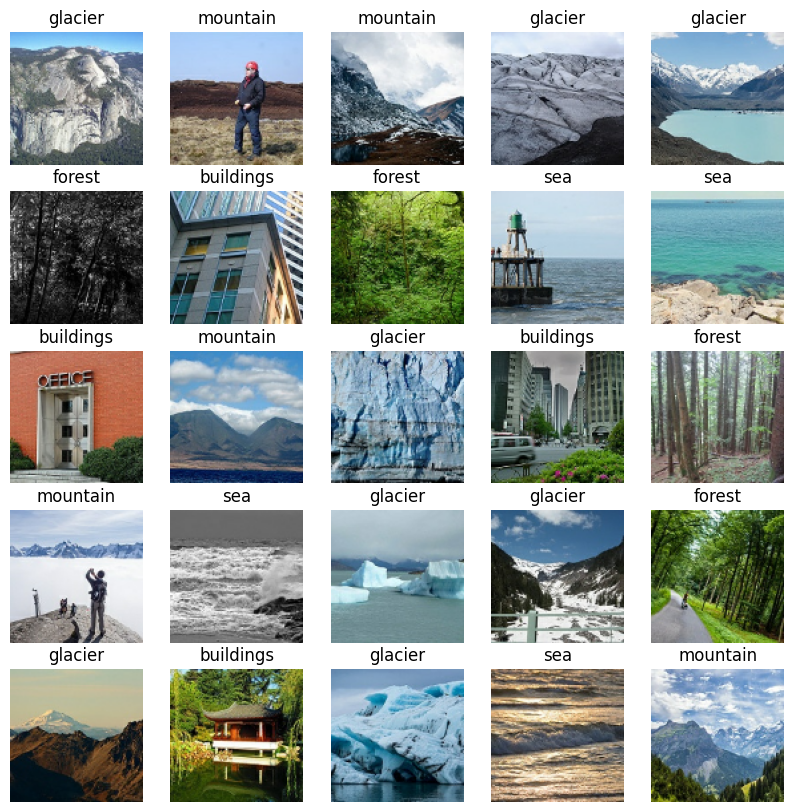

In [179]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes_names[labels[i]])
        plt.axis('off')


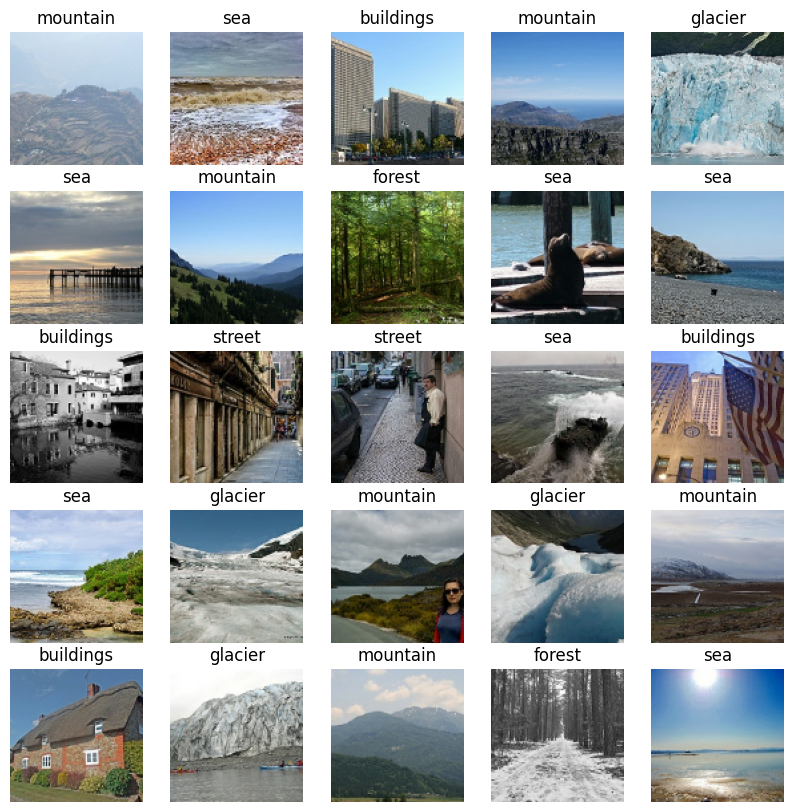

In [180]:
plt.figure(figsize=(10,10))
for image,labels in test_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off')


In [181]:
class_counts = {}
for class_name in os.listdir(trainpath):
    class_dir = os.path.join(trainpath, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images
buildings: 2191 images


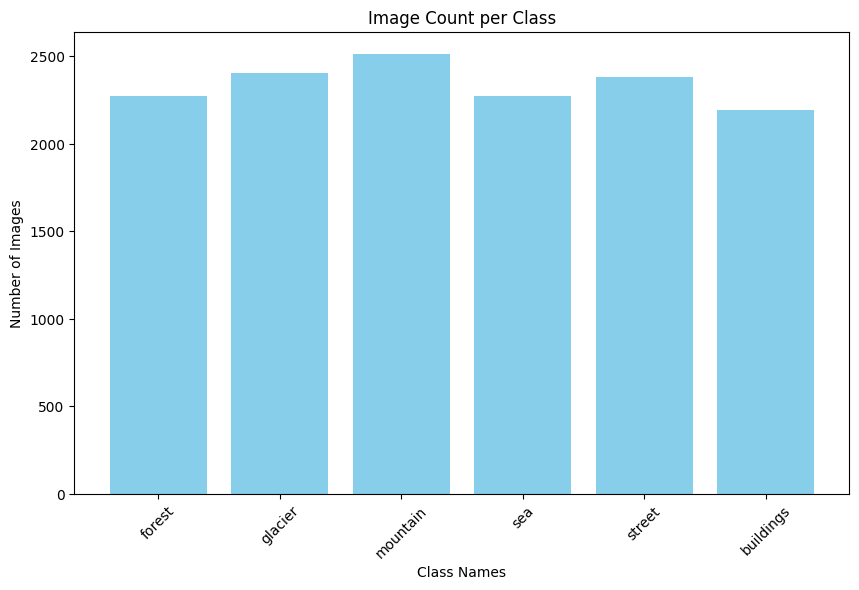

In [182]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [183]:
class_counts = {}
for class_name in os.listdir(testpath):
    class_dir = os.path.join(testpath, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts[class_name] = num_images
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


forest: 474 images
glacier: 553 images
mountain: 525 images
sea: 510 images
street: 501 images
buildings: 437 images


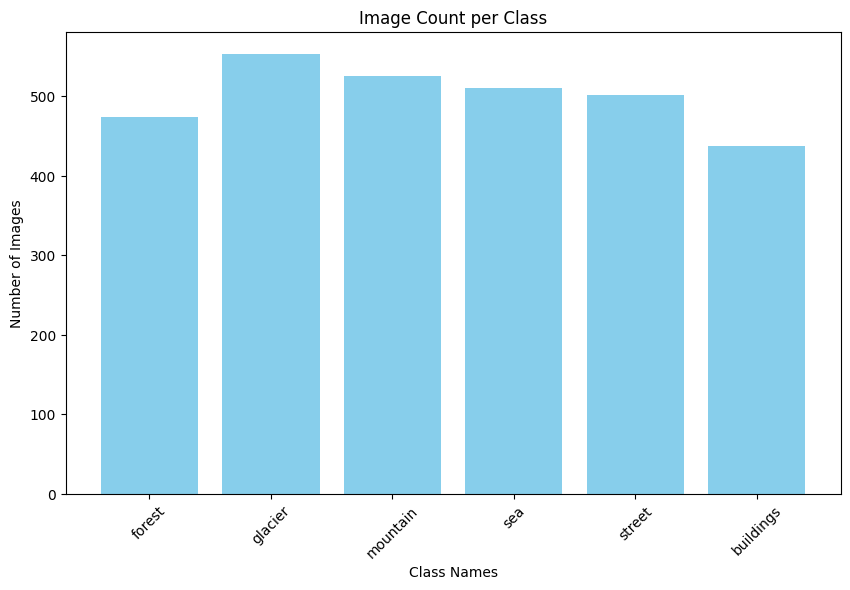

In [184]:
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [185]:
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

In [186]:
# упрощенная модель для скорости
model = Sequential([
    Input(shape=(100, 100, 3)),
    Conv2D(16, (3, 3), activation='relu'),  # Меньше фильтров
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),  # Меньше нейронов
    Dropout(0.3), #величен ДО 0.3
    Dense(len(classes_names), activation='softmax')
])

In [187]:
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 16928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       2,166,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,172,774 (8.29 MB)

 Trainable params: 2,172,774 (8.29 MB)

 Non-trainable params: 0 (0.00 B)

In [188]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [189]:
early_stopping=EarlyStopping(monitor='val_accuracy',patience=2,restore_best_weights=True) #уменьшено терпение EarlyStopping (2 вместо 5)

In [190]:
history=model.fit(train_ds,
                  validation_data=test_ds,
                  epochs=5,
                  callbacks=[early_stopping]
                  ) #  сокращено число эпох (5 вместо 100)

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4774 - loss: 1.3208 - val_accuracy: 0.6810 - val_loss: 0.8636
Epoch 2/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.6948 - loss: 0.8307 - val_accuracy: 0.7370 - val_loss: 0.7274
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7441 - loss: 0.7030 - val_accuracy: 0.7447 - val_loss: 0.7095
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.7861 - loss: 0.6018 - val_accuracy: 0.7747 - val_loss: 0.6314
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8081 - loss: 0.5372 - val_accuracy: 0.7797 - val_loss: 0.6416


In [191]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 276ms/step - accuracy: 0.7777 - loss: 0.6516
Test accuracy: 77.97%


In [192]:
loss, accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {accuracy * 100:.2f}%')


110/110 ━━━━━━━━━━━━━━━━━━━━ 35s 318ms/step - accuracy: 0.8522 - loss: 0.4236
Train accuracy: 85.68%


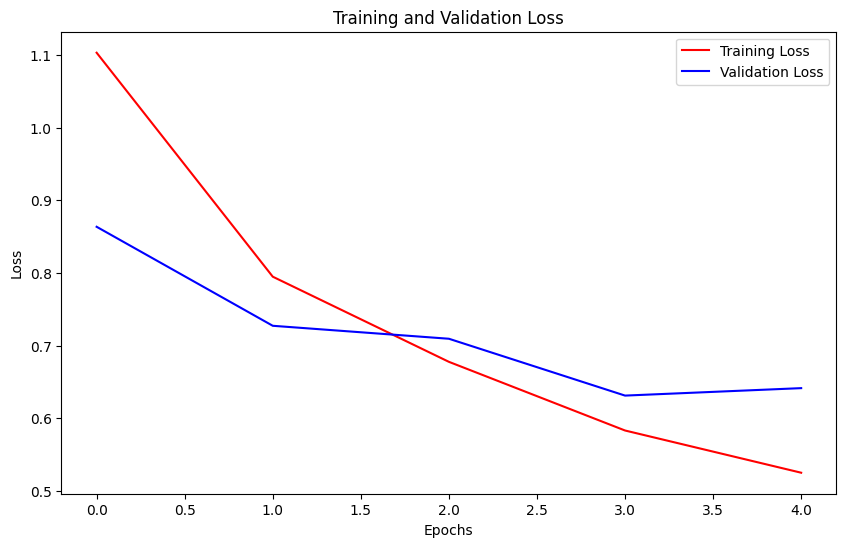

In [193]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


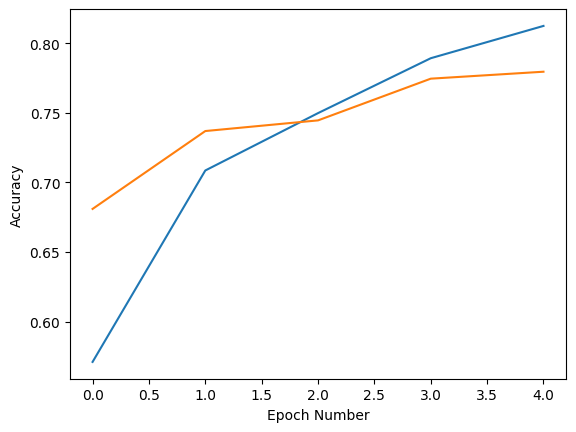

In [194]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.show()

In [195]:
def predict_img(file_name,model):
    from PIL import Image
    import numpy as np
    img = Image.open(file_name).resize((IMAGE_SIZE))
    img_pro = np.expand_dims(np.asarray(img, dtype=np.float32),axis=0)
    img_pro/=255
    img_pred=model.predict(img_pro)
    index = np.argmax(img_pred)

    plt.title("Prediction - {}".format(str(classes_names[index]).title()), size=18, color='red')
    plt.imshow(img)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


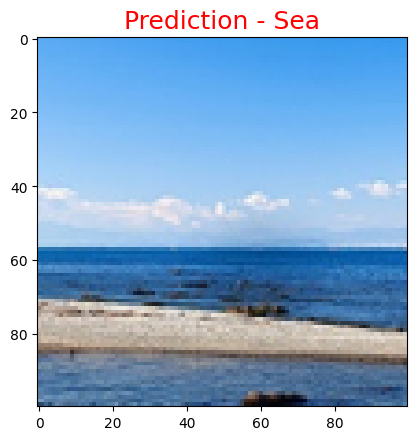

In [196]:
predict_img(f'{path}/seg_pred/seg_pred/1003.jpg', model)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
              precision    recall  f1-score   support

   buildings       0.75      0.

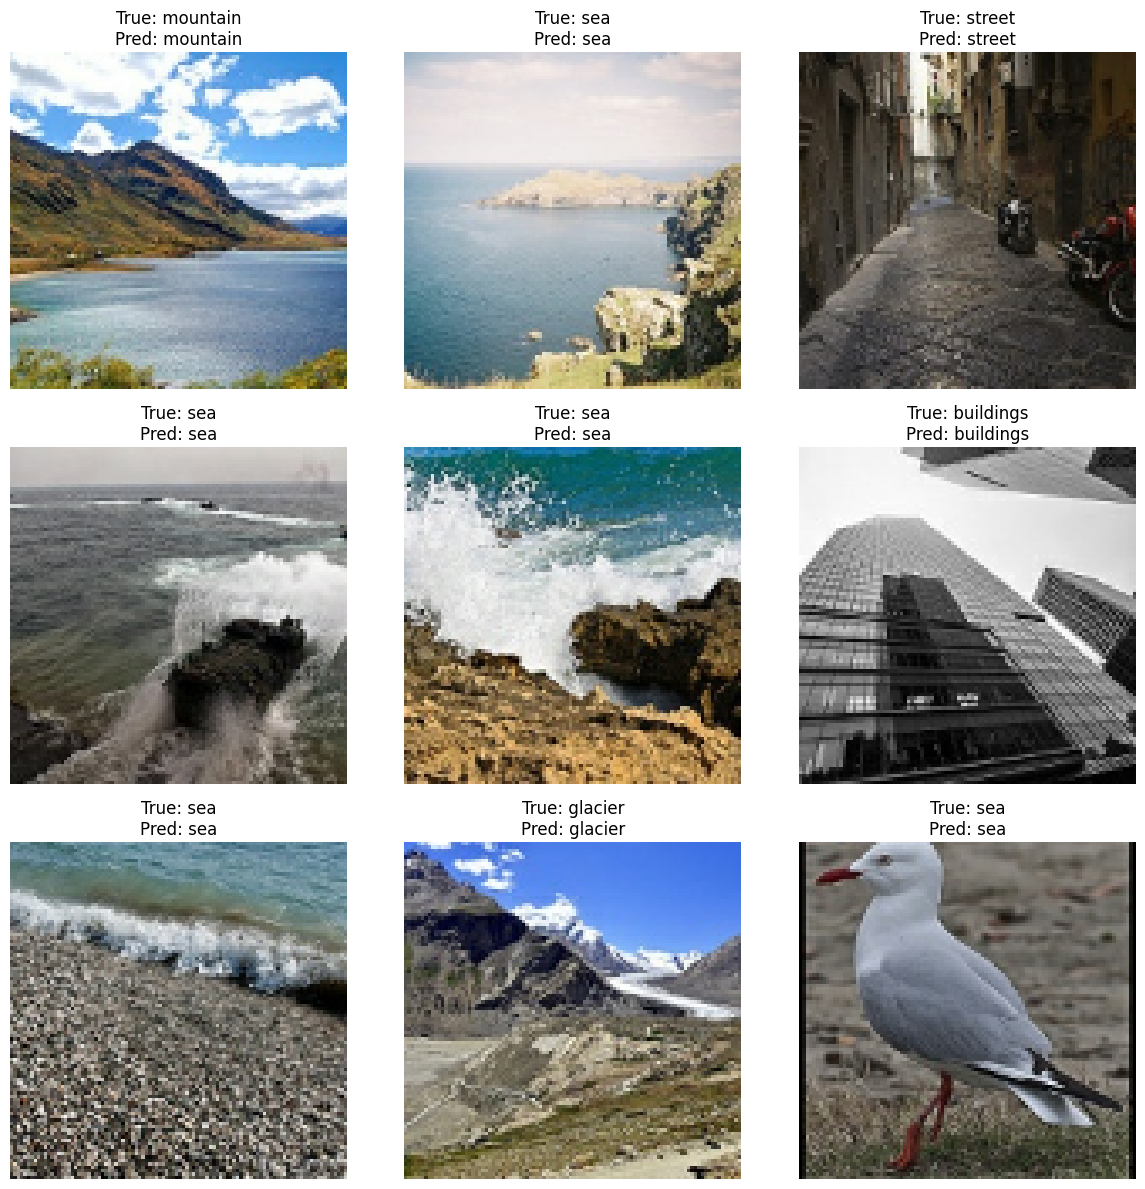

In [197]:
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=classes_names)
print(report)

misclassified_indices = np.where(y_true != y_pred)[0]

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

for i, (images, labels) in enumerate(test_ds):
    if i * BATCH_SIZE >= len(y_true):
        break
    for j in range(len(images)):
        if len(misclassified_indices) == 0:
            break
        if (i * BATCH_SIZE + j) in misclassified_indices:
            misclassified_images.append(images[j].numpy())
            misclassified_labels.append(classes_names[labels[j]])
            misclassified_preds.append(classes_names[y_pred[i * BATCH_SIZE + j]])



plt.figure(figsize=(12, 12))
for i in range(min(9, len(misclassified_images))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((misclassified_images[i] * 255).astype("uint8"))
    plt.title(f"True: {misclassified_labels[i]}\nPred: {misclassified_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()